In [1]:
from solcore import si, material
from solcore.structure import Layer, Structure, Junction
from solcore.solar_cell import SolarCell
import solcore.quantum_mechanics as QM
import solcore.poisson_drift_diffusion as PDD
import numpy as np
from solcore.light_source import LightSource
from solcore.solar_cell_solver import solar_cell_solver
import matplotlib.pyplot as plt
import os
import shutil

c:\Users\usuwa\PycharmProjects\Solarcell\venv\lib\site-packages\solcore\registries.py:73: UserWarning: Optics solver 'RCWA' will not be available. An installation of S4 has not been found.
  warn(


In [3]:
wl = np.linspace(350, 1200, 401) * 1e-9
light_source = LightSource(
    source_type="standard",
    version="AM1.5g",
    x=wl,
    output_units="photon_flux_per_m",
    concentration=1,
)


In [4]:
T = 298
wl = np.linspace(350, 1050, 301) * 1e-9
# First, we create the materials of the QW
# สร้างวัสดุทำรับQW ในsolar cell
QWmat = material("InGaAs")(T=T, In=0.2, strained=True)
Bmat = material("GaAsP")(T=T, P=0.1, strained=False)
i_GaAs = material("GaAs")(T=T)
i_GaAs_dope = material("GaAs")(T=T, Na=1e14)
n_GaAs = material("GaAs")(T=T, Nd=1e24)
p_GaAs = material("GaAs")(T=T, Na=8e22)


In [5]:
QW = PDD.QWunit([
    Layer(width=5e-9, material=Bmat, role="barrier"),
    Layer(width=3e-9, material=i_GaAs, role="interlayer"),
    Layer(width=7e-9, material=QWmat, role="well"),
    Layer(width=3e-9, material=i_GaAs, role="interlayer"),
    Layer(width=5e-9, material=Bmat, role="barrier")
], T=T, repeat=30, substrate=i_GaAs, )
QW_list = QW.GetEffectiveQW(wavelengths=wl, mode="kp6x6")
GaAs_junction = Junction(
    [Layer(width=150e-9, material=n_GaAs, role="Emitter"),]
     # Layer(width=barrier, material=Bmat, role="barrier")]
    + QW_list
    # + [Layer(width=barrier, material=Bmat, role="barrier"),
    +[Layer(width=2000e-9, material=p_GaAs, role="Base"),
    ],
    sn=1e6,
    sp=1e6,T=T,kind="PDD",)

Solving QW properties...


Calculation finished!!
Organising the bands into E, HH and LH


In [9]:
GaAs_junction = Junction(
     [Layer(width=150e-9, material=n_GaAs, role="Emitter"), ]
     # Layer(width=barrier, material=Bmat, role="barrier")]
     # + QW_list
         # + [Layer(width=barrier, material=Bmat, role="barrier"),
     +[Layer(width=2000e-9, material=p_GaAs, role="Base"),
     ],
     sn=1e6,
     sp=1e6, T=T, kind="PDD", )

In [10]:
my_solar_cell = SolarCell([
    # [Layer(width=110e-9, material=MgF2, role="ARC1"),
    # Layer(width=60e-9, material=ZnS, role="ARC2")
                        GaAs_junction,]
                          ,T=T,substrate=p_GaAs,)
solar_cell_solver(my_solar_cell, "qe",
                  user_options={"light_source": light_source,
                                "wavelength": wl,
                                "optics_method": "TMM",}, )


Calculating RAT...
Calculating absorption profile...
Solving QE of the solar cell...
Solving quantum efficiency...
Processing structure...
...done!

Solving equilibrium...
...done!

...done!

...done!



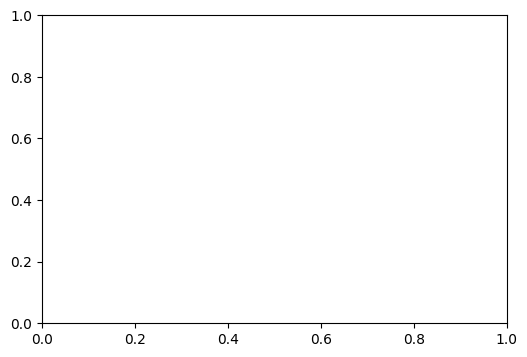

In [7]:
vint = np.linspace(-3.5, 4, 600)
V = np.linspace(-3.5, 0, 300)
allI = []; isc = []; voc = []; FF = []; pmpp = []
fig3, axIV = plt.subplots(1, 1, figsize=(6, 4))

In [11]:
solar_cell_solver(my_solar_cell,"iv"
                  ,user_options={"light_source": light_source,
                                "wavelength": wl,
                                 "optics_method": None,
                                 "light_iv": True,
                                 "mpp": True,
                                 "voltages": V,
                                 "internal_voltages": vint,
                    },)
isc.append(my_solar_cell.iv["Isc"])
voc.append(my_solar_cell.iv["Voc"])
FF.append(my_solar_cell.iv["FF"])
pmpp.append(my_solar_cell.iv["Pmpp"])
allI.append(my_solar_cell.iv["IV"][1])


Solving IV of the junctions...
Solving IV...
Processing structure...
...done!

Solving equilibrium...
...done!

...done!

Processing structure...
...done!

Solving equilibrium...
...done!

...done!

...done!

Solving IV of the tunnel junctions...
Solving IV of the total solar cell...


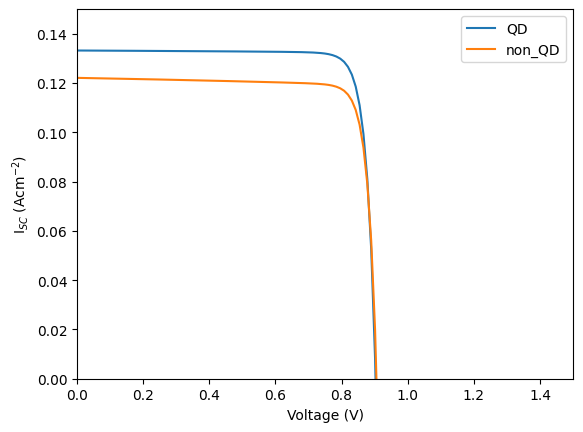

In [12]:
plt.plot(-V, allI[0] / -1e3, label='QD') 
plt.plot(-V, allI[1] / -1e3, label='non_QD')
plt.ylim(0, 0.15)
plt.ylabel("I$_{SC}$ (Acm$^{-2}$)")
plt.xlabel("Voltage (V)")
plt.xlim(0, 1.5)
plt.legend()
plt.savefig('QD_vs_nonQD.png', dpi=300)